In [1]:
import os
#if not os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
#    raise 'stop'
if not os.path.isdir('d:/flagellar/'):
    deps_path = '/kaggle/usr/lib/flg-packages/'
    !pip install --no-index --find-links {deps_path} --requirement {deps_path}/requirements.txt
    !tar xfvz /kaggle/input/ultralytics-for-offline-install/archive.tar.gz
    !pip install --no-index --find-links=./packages ultralytics
    !rm -rf ./packages

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import sys
sys.path.append('d:/flagellar/code/core')
sys.path.append('/flagellar/code/core/')
sys.path.append('/kaggle/input/my-flagellar-library/')
import flg_support as fls
import flg_unet
import flg_numerics
import flg_model
import importlib
import numpy as np
import matplotlib.pyplot as plt
import time
import copy
import flg_yolo

fast_mode = False
if fls.is_submission:
    fast_mode = False

MainProcess


In [4]:
all_data = fls.load_all_train_data()
np.random.default_rng(seed=0).shuffle(all_data)

# Pick N tomograms with 1 motor and N tomograms with 0 motors as validation set
N=100
n_motors = np.array([len(d.labels) for d in all_data])
inds_zero = np.argwhere(n_motors==0)[:N,0]
inds_one = np.argwhere(n_motors==1)[:N,0]
inds_test = np.concatenate((inds_zero,inds_one))
inds_train = np.setdiff1d(np.arange(len(n_motors)), inds_test)
inds_test.shape, inds_train.shape

train_data = []
for i in inds_train:
    train_data.append(all_data[i])
test_data = []
for i in inds_test:
    test_data.append(all_data[i])
np.random.default_rng(seed=0).shuffle(test_data)
test_data = test_data
if fast_mode:
    train_data = train_data[1:30]
    test_data = test_data[2:4]
len(train_data), len(test_data)

(444, 200)

In [4]:
model = flg_model.TwoStepModel()
model.seed = 42
model.run_in_parallel = True
if fast_mode: model.n_epochs = 1
model.train(train_data, test_data)
if not fls.env=='kaggle':
    fls.dill_save(fls.model_dir+ "yolo.pickle", model)

CompletedProcess(args=['pip', 'uninstall', '-y', 'albumentations'], returncode=0)
Will process approximately 3123 slices for training


Processing training motors:   0%|          | 0/347 [00:00<?, ?it/s]

Clearing pytorch
Will process approximately 900 slices for validation


Processing validation motors:   0%|          | 0/100 [00:00<?, ?it/s]


Preprocessing Complete:
- Training data: 258 tomograms, 347 motors, 3118 slices
- Validation data: 100 tomograms, 100 motors, 900 slices
- Dataset directory: d:/flagellar/temp//yolo_dataset/
- YAML configuration: d:/flagellar/temp//yolo_dataset/dataset.yaml

Ready for YOLO training!
Starting YOLO training process...
Created new YAML at d:/flagellar/temp/training.yaml
Using YAML file: d:/flagellar/temp/training.yaml
YAML contents:
names:
  0: motor
path: d:/flagellar/temp//yolo_dataset/
train: images/train
val: images/val


Starting YOLO training...
New https://pypi.org/project/ultralytics/8.3.106 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.98  Python-3.10.14 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 4070 Ti, 12282MiB)
engine\trainer: task=detect, mode=train, model=yolov8m.pt, data=d:/flagellar/temp/training.yaml, epochs=30, time=None, patience=10, batch=16, imgsz=640, save=True, save_period=5, cache=False, device=None, workers=4, project=d:/flagellar/temp//yolo_we


train: Scanning D:\flagellar\temp\yolo_dataset\labels\train... 3118 images, 0 backgrounds, 0 corrupt: 100%|██████████| 

train: New cache created: D:\flagellar\temp\yolo_dataset\labels\train.cache



val: Scanning D:\flagellar\temp\yolo_dataset\labels\val... 900 images, 0 backgrounds, 0 corrupt: 100%|██████████| 900/9

val: New cache created: D:\flagellar\temp\yolo_dataset\labels\val.cache
Plotting labels to d:\flagellar\temp\yolo_weights\motor_detector\labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to d:\flagellar\temp\yolo_weights\motor_detector
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08

                   all        900        900      0.295      0.354      0.196     0.0387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07

                   all        900        900      0.671       0.62      0.627      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07

                   all        900        900       0.61       0.52      0.505      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07

                   all        900        900      0.712      0.651      0.664      0.223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07

                   all        900        900      0.781      0.708      0.775      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07

                   all        900        900      0.634      0.582      0.515      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07

                   all        900        900      0.718      0.616      0.656      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07

                   all        900        900      0.865      0.764      0.842      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07

                   all        900        900      0.844      0.769      0.813       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07

                   all        900        900      0.905      0.789      0.858      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07

                   all        900        900      0.859      0.812      0.869      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07

                   all        900        900      0.886      0.771       0.81      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07

                   all        900        900      0.912       0.82      0.876       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07

                   all        900        900      0.884      0.752      0.831      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07

                   all        900        900        0.9      0.848      0.902      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07

                   all        900        900      0.923      0.852      0.912      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07

                   all        900        900      0.919      0.868      0.917        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07

                   all        900        900      0.885      0.796      0.856      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07

                   all        900        900      0.924      0.852      0.907      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07

                   all        900        900      0.956      0.822      0.908      0.397


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07

                   all        900        900      0.898      0.784      0.828      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07

                   all        900        900      0.887      0.806      0.844      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07

                   all        900        900      0.929      0.818      0.901      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07

                   all        900        900      0.937      0.806      0.892      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07

                   all        900        900        0.9      0.826      0.889      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07

                   all        900        900      0.903      0.849      0.909      0.383
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 16, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



26 epochs completed in 0.416 hours.
Optimizer stripped from d:\flagellar\temp\yolo_weights\motor_detector\weights\last.pt, 52.2MB
Optimizer stripped from d:\flagellar\temp\yolo_weights\motor_detector\weights\best.pt, 52.2MB

Validating d:\flagellar\temp\yolo_weights\motor_detector\weights\best.pt...
Ultralytics 8.3.98  Python-3.10.14 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 4070 Ti, 12282MiB)
Model summary (fused): 92 layers, 25,840,339 parameters, 0 gradients, 78.7 GFLOPs



                Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11

                   all        900        900      0.771      0.848      0.869       0.42
Speed: 0.1ms preprocess, 7.9ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to d:\flagellar\temp\yolo_weights\motor_detector
Loss curve saved to d:/flagellar/temp//yolo_weights/motor_detector\dfl_loss_curve.png

Best model found at epoch 736 with validation DFL loss: 0.0000

Training complete!


In [5]:
if not fls.is_submission:
    importlib.reload(flg_yolo)    
    inferred_test_data = model.infer(test_data[:20])
    print(fls.score_competition_metric(inferred_test_data, test_data[:20]))

Clearing cupy
0.873015873015873


In [ ]:
inferred_test_data2 = model.infer(fls.load_all_test_data())
fls.write_submission_file(inferred_test_data2)

Number of true positives before filter:  42


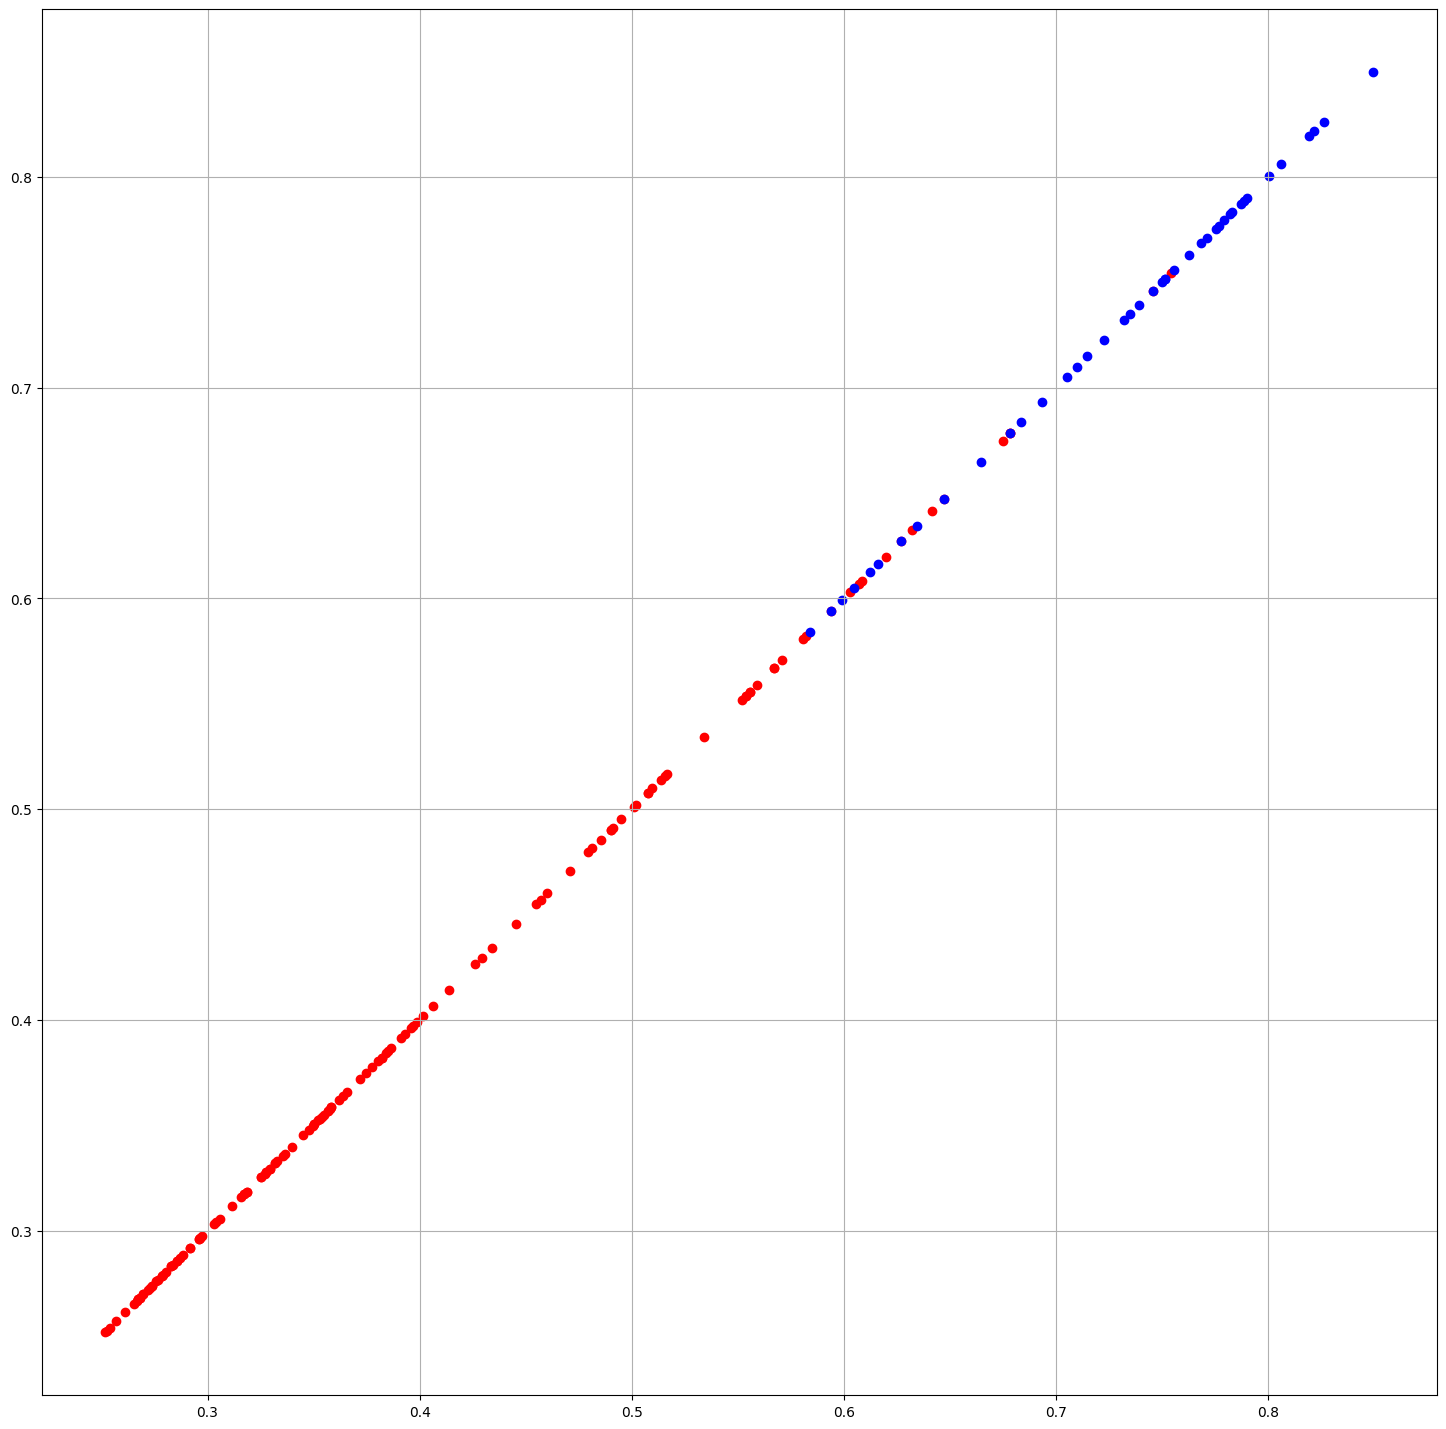

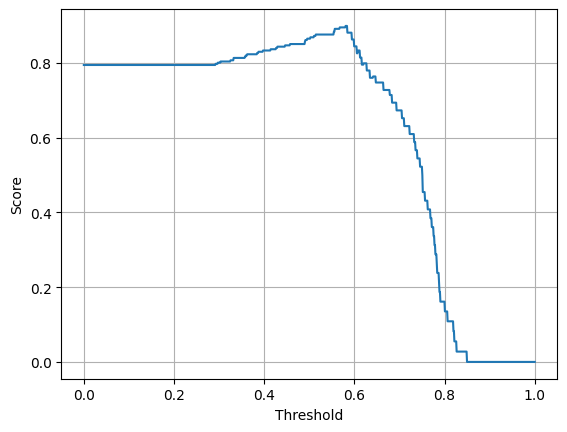

In [6]:
model = fls.dill_load(fls.model_dir+ "yolo.pickle")
model.state = 0
model.calibrate_step_2 = True
model.train(train_data, test_data[101:200])